<a href="https://colab.research.google.com/github/antmillar/latentSDF/blob/master/Model_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepSDF Model Trainer

This Colab Jupyter Notebook allows a DeepSDF model to be trained on binary images of architectural floorplans

This model and the latent vectors can then be used in the latent designer tool

Please run the cells in order and follow the "ACTION" cues in the descriptions 

It's recommended to use GPU to speed up training : Runtime > Change Runtime Type > GPU



## Import Libraries


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.colors as colors

import torch
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import cv2 as cv
from functools import partial

from zipfile import ZipFile
from os.path import basename

!pip install --upgrade PyMCubes
!pip install pycollada

import mcubes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Requirement already up-to-date: PyMCubes in /usr/local/lib/python3.6/dist-packages (0.1.2)



## Define DeepSDF Architecture

This is the DeepSDF architecture for both shape-coded and auto-decoder architecture, setting the self_learn boolean at training time determines this.


In [4]:
class deepSDF(nn.Module):

    def __init__(self, data_size, input_dim = 2, code_dim = 2, hidden_dim = 256, num_layers = 8, skip_layers = [4]):

      super().__init__()  

      self.skip_layers = skip_layers
      self.num_layers = num_layers
      self.linears = nn.ModuleList()
      self.linears.append(nn.Linear(input_dim + code_dim, hidden_dim))

      for i in range(1, num_layers):
        #skip layers
        if( i + 1 in skip_layers):
          self.linears.append(nn.Linear(hidden_dim, hidden_dim - (input_dim + code_dim)))
        
        #final layer
        elif(i == num_layers - 1):
          self.linears.append(nn.Linear(hidden_dim, 1))
        
        #standard linear layers
        else:
          self.linears.append(nn.Linear(hidden_dim, hidden_dim))

      self.tanh = nn.Tanh()

      self.latents = nn.Parameter(torch.FloatTensor(data_size, code_dim))
      torch.nn.init.xavier_normal(self.latents)

    def forward(self, shape_code, coord, self_learn = False):

      coord = coord.float()

      #if self_learn the shape_code is actually an index
      if(not self_learn):
        shape_code = shape_code.float()
        shape_code = shape_code.repeat(coord.shape[0], 1)
      else:
        shape_code = self.latents[shape_code].repeat(coord.shape[0], 1)


      input = torch.cat((shape_code, coord), dim = 1)
      x = input

      for i, layer in enumerate(self.linears):
        x = layer(x)

        if(i == self.num_layers - 1):
          x = self.tanh(x)
        else:
          x = F.relu(x)

        if(i + 1 in self.skip_layers):  
          x = torch.cat((x, input), dim = 1) #skip connection

      return x

##User Inputs

ACTION : Please provide a list of input image filenames and update the folder they're uploaded to below. These images must be binary black and white images of 1x1 aspect ratio, where black represents the building, white the outside. 

ACTION : Please follow instructions to mount google drive and copy/paste the link

The image on the right is an example of a suitable input. Currently this is generated manually by the author, however the plan is to eventually automate the process.


![floorplan](https://drive.google.com/uc?export=view&id=1Z6vB3E-LmNPOk-v4ORmeNtYdFCOi_h29)


The author trained models using images of size 512 x 512, a sample set of images is available [here](https://drive.google.com/file/d/1XOPPwtd2elSpsvzDnCq3xV1PO_MbMwXw/view?usp=sharing) 

Additional supplementary information can be provided as shown in the example


---


*Reference : Type 7C Barbican Estate flats, floor plan, accessed August 2020, <http://www.barbicanliving.co.uk/wp-content/uploads/2015/11/7C.jpg>*

In [27]:
#--------PLEASE MODIFY-------------

data_dir = "/content/drive/My Drive/deepSDF/expD/"

filenames = ['mask_leeza.jpg','mask_commerz.jpg','mask_stratford.jpg','mask_scalpel.jpg']


###################################

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Add supplementary information

Additional supplementary information can be added for annotations in the application. Please fill the lists below, if not required use_annotations can be set to False

In [28]:
#--------CAN BE MODIFIED-------------
use_annotations = False


buildings = ["Morpheus Hotel", "Morpheus Hotel", "Stratford Tower", "The Scalpel", "Commerzbank", "The Gherkin", "Absolute Tower", "Leeza", "Soho Galaxy"]
architects = ["Zaha", "Zaha", "SOM", "KPF", "Fosters", "Fosters", "MAD", "Zaha", "Zaha"]
floors = [0,0,0,"-",0,0]

###################################

if(use_annotations):
  #checks
  assert len(buildings) == len(filenames), f"Length of building and filenames lists must match"
  assert len(architects) == len(filenames), f"Length of architects and filenames lists must match"
  assert len(floors) == len(filenames), f"Length of floors and filenames lists must match"

  annotations = {idx: [fn, bldg, arch, fl] for idx, (fn, bldg, arch, fl) in enumerate(zip(filenames, buildings, architects, floors))}

else:

  default = ["-" ] * len(filenames)
  annotations = {idx: [fn, bldg, arch, fl] for idx, (fn, bldg, arch, fl) in enumerate(zip(filenames, default, default, default))}

print(annotations)

{0: ['mask_leeza.jpg', '-', '-', '-'], 1: ['mask_commerz.jpg', '-', '-', '-'], 2: ['mask_stratford.jpg', '-', '-', '-'], 3: ['mask_scalpel.jpg', '-', '-', '-']}


##Load Images and Generate Signed Distance Fields

Loads the user supplied images and convert them to SDFs


generating sdf for  mask_leeza.jpg
generating sdf for  mask_commerz.jpg
generating sdf for  mask_stratford.jpg
generating sdf for  mask_scalpel.jpg


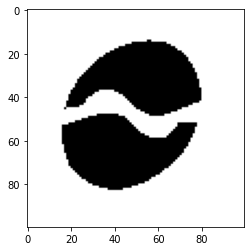

In [29]:
size = 100

sdfs = {}


def generateSDF(src):

  bw = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
  _, bw = cv.threshold(bw, 40, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

  bwInvert = cv.bitwise_not(bw)
  dist = cv.distanceTransform(bw, cv.DIST_L2, 3, cv.DIST_LABEL_PIXEL )
  distIn = cv.distanceTransform(bwInvert, cv.DIST_L2, 3, cv.DIST_LABEL_PIXEL )

  dist -= distIn

  absMin = abs(np.min(dist))
  absMax = abs(np.max(dist))

  absAbsMax = max(absMin, absMax)

  #rescale to [-1, 1]
  dist /= absAbsMax

  #flatten
  dist = dist.reshape((size * size))

  return dist


for i in range(len(filenames)):
    print("generating sdf for ", filenames[i])
    im  = cv.imread(data_dir + filenames[i])
    im = cv.resize(im, (size, size))
    sdfs[i] = generateSDF(im)

ptsDisc = np.float_([[x, y] 
                    for x in  np.linspace(-50, 50, size) 
                    for y in np.linspace(-50, 50, size)])


mask = sdfs[0].reshape(size, size) > 0

#display test image
plt.imshow(cv.cvtColor(mask.astype(int).astype('float32'), cv.COLOR_BGR2RGB))
plt.show()

##Initialise Model

ACTION : Please select whether to use self-learnt or pre-defined latent vectors by setting the self_learn boolean.

In [30]:
#--------CAN BE MODIFIED-----------

self_learn = False

###################################

model = deepSDF(data_size = len(sdfs)).to(device)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


##Prepare Data Sets

In [31]:
train_dls = []
codes = []

def generateLatents(num):
  '''
  Generates a list of latent vectors for a given number of input floorplans. Does this by placing latent vectors on a 1.0 x 1.0 grid.

  '''
  gridSide = int(np.ceil(np.sqrt(num)))

  for i in range(num):
    codes.append(torch.Tensor(np.array([i % gridSide, i // gridSide])))
  

for key, value in sdfs.items():
  
  train_ds = TensorDataset(torch.Tensor(ptsDisc), torch.Tensor(value))
  train_dl = DataLoader(train_ds, shuffle=True, batch_size=len(train_ds))
  # code = torch.Tensor(np.array([0, 0]))

  train_dls.append(train_dl)


if(self_learn):
  
  #create numbered indices for each model
  codes = [i for i in range(len(sdfs))]
  print("self learn mode : generated indices : ", codes)
else:

  #create predefined latent vectors for each model
  
  generateLatents(len(sdfs))
  print("pre defined mode : generated latent predefined latent vectors : ", codes)



pre defined mode : generated latent predefined latent vectors :  [tensor([0., 0.]), tensor([1., 0.]), tensor([0., 1.]), tensor([1., 1.])]


##Plotting Function

In [33]:
def plot_sdf_from_latent(latent, sdf_func, show_axis=True, show_title=True, ax = False, count = False, self_learn = False):

    # See https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib

    size = 200
    xAxis =  np.linspace(-50, 50, size)
    yAxis =  np.linspace(50, -50, size)

    x, y = np.meshgrid(xAxis, yAxis)
    

    pts = np.float_([[x, y] 
                    for x in  np.linspace(-50, 50, size) 
                    for y in np.linspace(-50, 50, size)])

    coord = torch.Tensor(pts)
    z = sdf_func(latent, coord.to(device), self_learn = self_learn)
    z = z.view(size, size).cpu().detach().numpy()

    z_min, z_max = -np.abs(z).max(), np.abs(z).max()
   
    if(not ax):
      fig, ax = plt.subplots(figsize=(3, 3))

    if(not show_axis):
      ax.axis('off')

    if(show_title):
      ax.set_title(np.round(latent.cpu().detach().numpy(), 2))

    c = ax.pcolormesh(x, y, z, cmap="RdBu", vmin=z_min, vmax=z_max)


##Train Model

Trains the chosen model

You can train for longer simply by running the cell again, and interrupt training by stopping it. In order to reset the training process you need to re-run the initialise model cell.

ACTION : Epochs and learning rates can be modified if wanted


In [ ]:
#--------CAN BE MODIFIED-----------

epochs = 1000
learning_rate = 0.0001
###################################




def train(model, train_dls, epochs, lr, plot_every = 50):

  optimizer = optim.Adam(model.parameters(), lr=lr)

  for e in range(epochs):

    loss = 0.0
    if(e % plot_every == 0): 

      fig, axs = plt.subplots(1, len(train_dls), figsize = (3 * len(train_dls), 3))

    for index, (latent, train_dl) in enumerate(zip(codes, train_dls)):


      if(not self_learn):
        latent = latent.to(device)

      for points, target in train_dl:

          optimizer.zero_grad()
          with torch.set_grad_enabled(True):

            # yhat = model(latent.to(device), points.to(device)).squeeze()
            yhat = model(latent, points.to(device), self_learn = self_learn).squeeze()

            loss = F.l1_loss(yhat, target.to(device))
          loss.backward()
          optimizer.step()

      if(e % plot_every == 0):
          
          if(len(train_dls) <= 1):
            axes = axs
          else:
            axes = axs[index]

          plot_sdf_from_latent(latent, model.forward, show_axis = False, show_title = False, ax = axes, self_learn = self_learn)  
                                       
              
    if(e % plot_every == 0):    
      print(f"Epoch : {e} | Loss : {loss.item()}") 

      if(self_learn):
        print("Latents : ", list(np.round((model.latents.cpu().detach().numpy()), 2)))
      else:
        print(codes)
      plt.show()

train(model.cuda(), train_dls, epochs, learning_rate)

##Save Model and Latent Vectors

Export the model and latent vectors to a zip file for use with latent explorer later

ACTION : Project can be renamed, this is the name of the zip file name that is generated


In [46]:
#--------CAN BE MODIFIED----------

project_name = "Experiment_name"

###################################

#please don't amend these filenames as they are used in the app
path_model =  data_dir + "model.pth"
path_latents =  data_dir + "seeds.npy"
path_zip = data_dir + project_name + ".zip"

#save torch mode
torch.save(model.state_dict(),path_model)
print("saved")

#export latents

latents = []

if(self_learn):
  latents = model.latents.tolist()
  latents = [np.round(latent, 2).tolist() for latent in latents]
else:
  latents = [code.tolist() for code in codes]

#add annotation informations into the npy file
info = []
info.append(["Latent", "Filename", "Building", "Architect", "Floor"])

for (index, (latent, (fn ,  bldg, arch , fl))) in enumerate(zip(latents, annotations.values()))  :
  items =  [str(latent), fn, bldg, arch, fl]
  info.append(items)

info = np.array(info)

np.save(path_latents, info)
print(info)
#zip the model and latents into one file for extraction later in app

with ZipFile(path_zip, 'w') as zipObj2:
   # Add multiple files to the zip
   zipObj2.write(path_model, arcname = basename(path_model) )
   zipObj2.write(path_latents, arcname = basename(path_latents))

saved
[['Latent' 'Filename' 'Building' 'Architect' 'Floor']
 ['[0.0, 0.0]' 'mask_leeza.jpg' '-' '-' '-']
 ['[1.0, 0.0]' 'mask_commerz.jpg' '-' '-' '-']
 ['[0.0, 1.0]' 'mask_stratford.jpg' '-' '-' '-']
 ['[1.0, 1.0]' 'mask_scalpel.jpg' '-' '-' '-']]


## Display Grid of Interpolated Latent Vectors

Generates a grid of interpolated latent vectors, latent vectors of the inputs are highlighted in gold

ACTION : Can change the interpolation grid width as wished

input latents :  [[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0]]


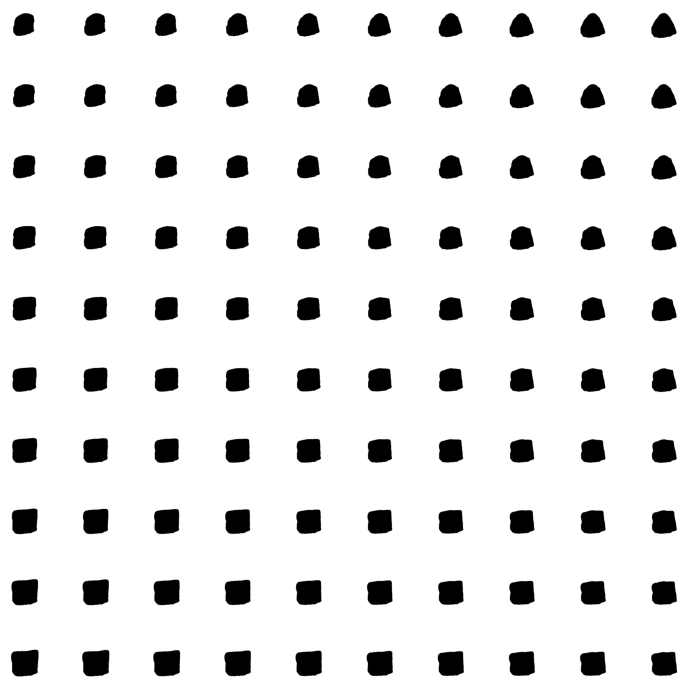

In [48]:
#---------CAN BE MODIFIED---------

interpolation_grid_width = 10

###################################
def latent_to_image(model, latent):

  '''
  Generates an image from  the model for the given latent vector
  '''
  
  size = 200
  ptsSample = np.float_([[x, y] 
                      for x in  np.linspace(-50, 50, size) 
                      for y in np.linspace(-50, 50, size)])

  coord = torch.Tensor(ptsSample).to(device)
  out = model.forward(latent.to(device), coord)
  pixels = out.view(size, size)
  plt.axis('off')
  plt.imshow(pixels.cpu().detach().numpy())

  mask = pixels < 0
  vals = mask.type(torch.uint8) 
  vals = vals.cpu().detach().numpy()
  return vals


def interpolate_grid(model, latentStart, latentEnd, num = 5):
  '''
  Generates a num x num grid of images of the latent space, where latentStart and latentEnd are the corners
  '''

  fig, axs = plt.subplots(num, num, figsize=(10, 10))
  fig.tight_layout(pad=1.0)
  x = np.linspace(latentStart[0], latentEnd[0], num)
  y = np.linspace(latentStart[1], latentEnd[1], num)

  for index, i in enumerate(x):
    for jindex, j in enumerate(y) :
    
      latent = torch.tensor( [float(i),  float(j)]).to(device)

      #inverting colors
      im = 1 - latent_to_image(model, latent)

      # #TODO MAKE dynamic
      # if([i, j] in latents):

      #   axs[jindex, index].imshow(im, cmap = "copper")
      # else:

      axs[jindex, index].imshow(im, cmap = "gray")
      
      
      axs[jindex, index].axis("off")


print("input latents : ", latents)

#calculate bounds of the latent vectors
minX = min(val[0] for val in latents)
maxX = max(val[0] for val in latents)
minY = min(val[1] for val in latents)
maxY = max(val[1] for val in latents)

#generate the grid and display
interpolate_grid(model, np.array([minX, -minY]), np.array([maxX, maxY]), num = interpolation_grid_width)
# print(latents)


##Generate Test Interpolated 3D Model

Generates a 3D model of a linear interpolation between latent vectors


In [38]:
#--------CAN BE MODIFIED----------

numSlices = 100
startInterpolation = torch.tensor([0, 0]).to(device)
endInterpolation = torch.tensor([1, 1]).to(device)

###################################

res = 100

pts = np.float_([[x, y] 
                      for y in  np.linspace(-50, 50, res) 
                      for x in np.linspace(-50, 50, res)])

pts = torch.Tensor(pts).to(device)

def createSlice(pts, latent):

  pixels = model.forward(latent, pts)
  return pixels.view(res, res)

latentRange = endInterpolation - startInterpolation 
latentStep = latentRange.div(float(numSlices))
slices = []

for i in range(numSlices):

  pixels = createSlice(pts, startInterpolation + i * latentStep)
  slices.append(pixels.detach().cpu())

print("slices compiled")

slices compiled


##Display Test 3D Model

dims :  (100, 100, 100)


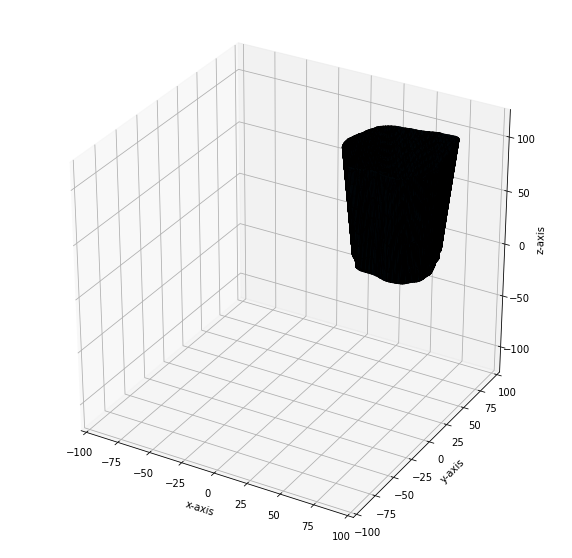

In [49]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

stacked = np.stack(slices)
print("dims : ", stacked.shape)

verts, faces = mcubes.marching_cubes(stacked, 0)

#rotate
verts[:,[0,2]] =  verts[:,[2,0]] 

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")

ax.set_xlim(-100, 100)  
ax.set_ylim(-100, 100) 
ax.set_zlim(-100 - 20, numSlices + 20)

plt.show()

#can export if required
# mcubes.export_obj(verts, faces, data_dir + "test.obj")